[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorial_notebooks/6_classification_tasks.ipynb) 

# Tutorial 7 - Neural Networks for Predictive Modeling
This notebook revisits our lecture on deep learning. We begin with examining the calculations in simple neural networks (NNs), which consists of chains of linear projections and nonlinear transformations. We reproduce this behavior using the `Numpy` library. Thereafter, we introduce the functionality of `sklearn` for developing NNs for regression and classification. The notebook concludes with three exercises concerning the architecture of NNs, how to define it in `sklearn`, and how its implications for NN training.

# Preliminaries
Execute the following code cells to setup the environment. 


In [95]:
# Standard imports
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Foundations of feedforward neural networks
This section revisits the deep learning lecture, illustrating discussed concepts using the *Numpy* library for scientific computing.

## Linear regression as directed graph
Let's begin by revisiting the calculation of a neural network (NN) in the simplest case possible, namely a linear regression model, which you can think of as the smallest possible "neural network".

First, we need some data. 
<p align="left">
  <img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/dl/Folie6.PNG" alt="NN as a directed graph" width="320" />
</p>

As this is just a demonstration, we create some synthetic data for a linear regression problem using only two features using the *sklearn* function `make_regression()`.


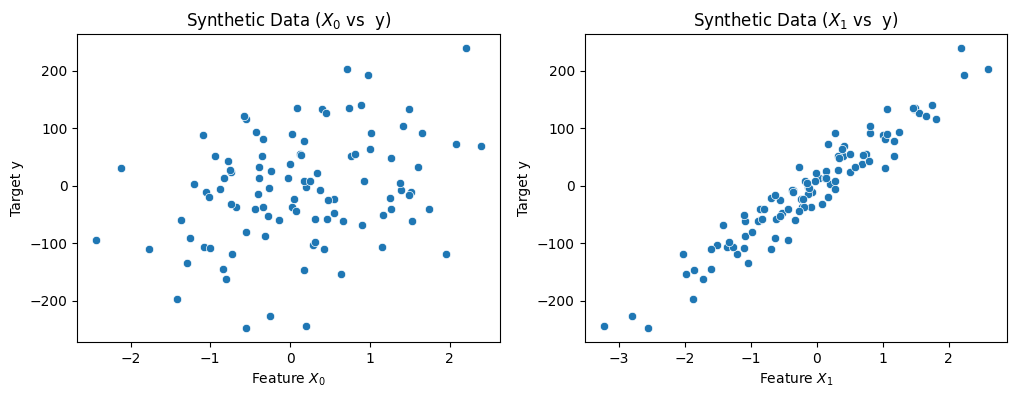

In [96]:
# Create synthetic data with two features for regression
from sklearn.datasets import make_regression
n_rows = 100
n_columns = 2
noise_level = 15
r_state = 123

X, y = make_regression(n_samples=n_rows, n_features=n_columns, n_informative=n_columns, bias=True, noise=noise_level, random_state=r_state)

# Plot the data in two scatter plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for i in np.arange(X.shape[1]):
    sns.scatterplot(x=X[:,i], y=y, ax=ax[i])
    ax[i].set_title(f'Synthetic Data ($X_{i}$ vs  y)')
    ax[i].set_xlabel(f'Feature $X_{i}$')
    ax[i].set_ylabel('Target y')    

plt.show()

The lecture suggested that we feed our data row-by-row through the neural network. 
<hr>
<table>
<tr>
<td>
<img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/dl/Folie7.PNG" alt="NN as a directed graph" width="320" />
</td>
<td>
<img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/dl/Folie10.PNG" alt="NN as a directed graph" width="320" />
</td>
</tr>
</table>
Let's implement this idea in code. Our data has two features. Thus, the input layer of our *mini-NN* has exactly this many nodes. The next *hidden* layer consists of only one node, as we reproduce a linear regression. Thus, our NN comprises three edges, each associated with a weight. These are the parameters of the NN (aka linear regression). To illustrate the calculation, we will sample weights randomly. 

In [97]:
# Randomly sample weights for our mini neural network
n_columns = X.shape[1]  # number of input features
w = np.random.randn(n_columns)  # for each feature, we need one weight w 
b = np.random.randn(1)  # we also need one bias term 

def mini_nn_predict(row, weights, bias):
    """Simple mini neural network prediction function effectively performing linear regression.
    
    Inputs:
        row (np.array): Input data row with two features.
        weights (np.array): Weights for the edges from input to hidden layer.
        bias (float): Bias term for the hidden layer node.
        
    Returns:
        float: Predicted target value.
    """
    # Compute the weighted sum of inputs plus bias
    z = np.dot(row, weights) + bias
    return z

# Loop through the dataset row by row and make predictions for each row
yhat = []  # list to store predictions
for i in np.arange(X.shape[0]):
    row = X[i, :]
    pred = mini_nn_predict(row, w, b)
    yhat.append(pred)

yhat = np.array(yhat)
# collect predictions into a DataFrame for comparison
results_df = pd.DataFrame({'Y': y, 'Yhat': yhat.flatten()})
results_df.head(10)  # preview first 10 predictions

,Y,Yhat
0,133.675167,-1.351619
1,37.826791,-0.988519
2,-225.613369,3.005350
3,-197.247444,0.036270
4,91.171195,1.451934
5,-119.181792,0.259918
6,52.444955,-3.070112
7,-47.439648,1.409706
8,-23.257666,0.240106
9,192.132116,-1.418593


Eyeballing the data is enough to see that the predictions are horrible. We could easily prove that by computing, for example, the root- mean squared error (RMSE) between the true and predicted target values:
```python
# RMSE of mini-NN
mse = np.mean( (y - yhat)**2)
print(f'Mean Squared Error: {np.sqrt(mse):.2f}')
``` 
However, as we have not trained the model in any way, but sampled the weights randomly, we should not expect useful predictions in the first place. The point of the demo is to illustrate the calculations of a NN from input to output; that is, how the data flows through the network structure. To better show this, let's next show a more efficient way to compute the predictions for all data points at once using matrix multiplications.

$$\hat{y} = X \cdot w + b$$

In [98]:
# More efficient prediction using matrix multiplication
# instead of looping through each row
yhat = np.dot(X, w) + b
# Add these predictions to the results DataFrame to prove they are the same
results_df["Yhat_matmul"] = yhat.flatten()
results_df.head(10)  

,Y,Yhat,Yhat_matmul
0,133.675167,-1.351619,-1.351619
1,37.826791,-0.988519,-0.988519
2,-225.613369,3.005350,3.005350
3,-197.247444,0.036270,0.036270
4,91.171195,1.451934,1.451934
5,-119.181792,0.259918,0.259918
6,52.444955,-3.070112,-3.070112
7,-47.439648,1.409706,1.409706
8,-23.257666,0.240106,0.240106
9,192.132116,-1.418593,-1.418593


We are getting closer to *real* networks. So far, we have only illustrated the data flow through a linear regression. In the lecture, we introduced NNs as a generalization of linear models where, in the hidden layer, we somewhat *run multiple regressions in parallel*. Another generalization we discussed concerns the use of *non-linear activation functions* in the hidden layers. 
<p align="left">
  <img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/dl/Folie22.PNG" alt="3 layer NN" width="640" />
</p>
Let's next illustrate these two concepts. As to the nonlinear activation, the function $g(\cdot)$ in the slide, we select the logistic (sigmoid) function. The below helper function `g_fun_logit()` provides an implementation of the logistic function:

$$ g(z) = \frac{1}{1 + e^{-z}} $$

In [101]:
#-------------------------------------------------------------------------------
# Ingredients of our first real NN
#-------------------------------------------------------------------------------
n_hidden_nodes = 2  # number of nodes in hidden layer
n_out = 1  # number of output nodes (for regression, typically 1)

# Helper function to compute logistic activation
def g_fun_logit(z):
    """Logistic (sigmoid) activation function."""
    return 1 / (1 + np.exp(-z))

# Matrix of weights from input layer to hidden layer (initialized randomly)
W_k = np.random.randn(n_columns, n_hidden_nodes) 
b_k = np.random.randn(n_hidden_nodes)  # bias vector for hidden layer (initialized randomly)

# Matrix of weights from hidden layer to output layer (initialized randomly)
V_k = np.random.randn(n_hidden_nodes, n_out) 
b = np.random.randn(n_out)  # bias for output layer (initialized randomly)

#-------------------------------------------------------------------------------
# Forward pass through the NN:
# (with many print statements to illustrate the shapes of the matrices/vectors)
#-------------------------------------------------------------------------------
print('Shape of the data is: ', X.shape)
print('Shape of the input-to-hidden layer weight matrix: ', W_k.shape)
# 1. Compute the input to the hidden layer (hL)
in_hL = np.dot(X, W_k) + b_k  # Linear transformation to hidden layer
print('Shape of the input to the hidden layer: ', in_hL.shape)
# 2. Apply activation function (logistic) to get hidden layer output (hL_out)
hL_out = g_fun_logit(in_hL) 
print('Shape of the output of the hidden layer: ', in_hL.shape)
# 3. Compute the input to the output layer (out_in)
print('Shape of the hidden-to-output layer weight matrix: ', V_k.shape)
out_in = np.dot(hL_out, V_k) + b  # Linear transformation to output layer
print('Shape of the input to the output layer: ', out_in.shape)
# 4. For regression, the output is just the linear output (no activation)
yhat = out_in
print('Shape of the final output predictions: ', yhat.shape)

Shape of the data is:  (100, 2)
Shape of the input-to-hidden layer weight matrix:  (2, 2)
Shape of the input to the hidden layer:  (100, 2)
Shape of the output of the hidden layer:  (100, 2)
Shape of the hidden-to-output layer weight matrix:  (2, 1)
Shape of the input to the output layer:  (100, 1)
Shape of the final output predictions:  (100, 1)


We recommend that you rerun the above code cell multiple times using different values for the number of hidden nodes, e.g., `n_hidden_nodes = 2`, `n_hidden_nodes = 5`, or `n_hidden_nodes = 10`. The print-statements allow you to observe how different settings for the number of hidden nodes translate into weigfht matrices of different sizes. Note also that the dimension of the input data and the NN outout do not change.

Having exemplified the data flow through a three-layer NN, we can use the demo to abstract a bit and think about deep neural networks with many layers and nodes. The lecture sketched the calculations of such networks using matrix multiplications and activation functions as follows.

<table>
<tr>
<td>
<img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/dl/Folie24.PNG" alt="NN forward path" width="320" />
</td>
<td>
<img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/dl/Folie25.PNG" alt="NN forward path" width="320" />
</td>
</tr>
</table>

Above we have seen, for each hidden layer, we need two weight matrices, one connecting the hidden layer to the previous layer, and one connecting it to the proceeding layer. The dimensionality of these matrices depends on the sizes of the involved layers. For each note in one layer, we need one weight (i.e., edge) to connect it to one node in the other layer. For example, above we defined our first matrix of weights as: 

```python
W1 = np.random.randn(n_columns, n_hidden_nodes) 
```

Once we know - or have decided on - the architecture of the NN (i.e., how many layers and the sizes of the layers), we can create all weight matrices accordingly. With these weight matrices, we can calculate the NN output, as exemplified above. However, the code can easily get messy unless we put effort into organizing the calculations and writing efficient code. For example, proper deep learning libraries like [Pytorch](https://pytorch.org/) or [Tensorflow](https://www.tensorflow.org/) use object-oriented programming concepts and abstract layers as classes. You can find many demos of how to implement a neural network *from scratch* online if interested. We while switch to ready-to-use implementations from here on and explore the functionality of *sklearn* for deep learning in the following. 

# Neural networks in SKLEARN
The *sklearn* library provides two classes for NNs, `MLPRegressor` and `MLPClassifier`, which support, respectively, regression and classification problems. 

## An NN for the synthetic data
Let's first revisit our synthetic regression data from above. Although a NN is much of an overkill for this simple toy problem, the dataset sufficies to get familiar with the key functions for training and prediction. Unsurprisingly, these are the same that every *sklearn* algorithm provides, `.train()` and `.predict()`. The next code cell provides a minimalistic demo of how to train and apply a NN to our toy data.  

In [102]:
from sklearn.neural_network import MLPRegressor  # importing the MLPRegressor class

nn = MLPRegressor(random_state=r_state)
nn.fit(X, y)  # training the NN on the synthetic data
yhat_nn = nn.predict(X)  # making predictions with the trained NN

results_df['Yhat_nn'] = yhat_nn  # Showcase NN predictions in our dataframe
results_df.head(10)

c:\Users\stefa\bads310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Y,Yhat,Yhat_matmul,Yhat_nn
0,133.675167,-1.351619,-1.351619,9.966203
1,37.826791,-0.988519,-0.988519,4.601888
2,-225.613369,3.005350,3.005350,-16.397532
3,-197.247444,0.036270,0.036270,-15.307619
4,91.171195,1.451934,1.451934,10.486204
5,-119.181792,0.259918,0.259918,-10.690436
6,52.444955,-3.070112,-3.070112,3.831822
7,-47.439648,1.409706,1.409706,-2.268279
8,-23.257666,0.240106,0.240106,-2.295312
9,192.132116,-1.418593,-1.418593,14.883822


You will have noticed a **warning message** from *sklearn* when executing the code cell above. The message informs us that the training of the NN did not converge. Eyeballing the predictions of the NN, you can also see that these are much better than the random predictions from before. However, they are still notably different from the true values of the target. This is surprising because a powerful NN should be able to perfectly fit such a simple linear regression problem. The reasons for suboptimal performance are twofold.

First, we did not configure our NN in any way. We did not say how many layers we want. We did not say how large these layers should be. We did not specify the activation function. We did not say how many iterations we allow for training. We did not say anything, but relied exclusively on default settings as implemented in *sklearn*. That is always a bad idea.

Second, when working with NNs, we must prepare the data properly. NNs are sensitive to the scaling of the input features. In our synthetic data, the two features have different scales. The scale of the target is also different. These differences in scales make it hard for the NN to learn the relationship between features and the target. We can fix the problem by standardizing the features using, for example, `StandardScaler` from *sklearn*:
```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
```
Furthermore, we should also scale the target variable for regression problems. From a theoretical perspective, scaling the target should not be necessary. Practically, however, it is often  difficult to train a good NN without scaling both, the features and the target. Adding scaling, the NN predictions become much better, as illustrated in the next code cell.

In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Scale feature values in our dataset and also the target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # some reshaping is necessary to get the code to work. You do not have to worry about this now.

# Repeat neural network training using the scaled data
nn = MLPRegressor(random_state=r_state)  # using one hidden layer with 5 nodes
nn.fit(X_scaled, y_scaled)  # training the NN on the synthetic data
yhat_nn = nn.predict(X_scaled)  # making predictions with the trained NN
yhat_nn = scaler.inverse_transform(yhat_nn.reshape(-1, 1)).flatten()  # inverse transform to original scale

results_df['Yhat_nn'] = yhat_nn  # Showcase NN predictions in our dataframe
results_df.head(10)

print(f'R2 score of the NN is {r2_score(y_true=y, y_pred=yhat_nn):.2f}')
results_df[["Y", "Yhat_nn"]].head(10)

R2 score of the NN is 0.97


,Y,Yhat_nn
0,133.675167,126.997515
1,37.826791,61.519365
2,-225.613369,-226.774401
3,-197.247444,-183.248181
4,91.171195,102.565635
5,-119.181792,-121.994977
6,52.444955,79.462218
7,-47.439648,-30.366412
8,-23.257666,-18.713416
9,192.132116,187.814273


Observing $R^2$ being close to 1 indicates that the NN has learned the underlying linear relationship in the data almost perfectly. However, the synthetic regression problem was very simple and a linear regression model would have performed just as good. Try it out yourself if interested:
```python
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)
yhat_lr = lr.predict(X)
print(f'R2 score of the LR is {r2_score(y_true=y, y_pred=yhat_lr):.2f}')
```
It is about time to move on to some more interesting and challenging data. Our standard HMEQ dataset will serve this purpose in the next section. Also, we still have to explore options to configure and tune NNs in *sklearn*. 

## A simple NN for classification
We explore the use of NNs for classification problems using our standard HMEQ dataset. Running the next code cell, you can download the **preprocessed data** right from our [GitHub repository](https://github.com/Humboldt-WI/bads), whereby the actual preprocessing is based on the helper function of [Tutorial 5](https://github.com/Humboldt-WI/bads/blob/master/tutorial_notebooks/5_data_prep_tasks.ipynb); just in case you are interested. To stress that this data is ready-for-use, the following code trains a logistic regression model, which will later serve as a baseline to our NN.

In [108]:
# Load the preprocessed data from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_prepared.csv'
df = pd.read_csv(data_url)
# Separate features and target
X = df.copy()
y = X.pop("BAD")
# Train a logistic regression model as a baseline
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=r_state)
lr_model.fit(X, y)
# Obtain probabilistic predictions
yhat_lr = lr_model.predict_proba(X)[:, 1]  # get predicted probabilities for the positive class
# Compute AUC score for information
from sklearn.metrics import roc_auc_score
print(f'ROC AUC score of the LR is {roc_auc_score(y_true=y, y_score=yhat_lr):.2f}')


ROC AUC score of the LR is 0.91


### NN Exercises
To practice the use of NNs in *sklearn*, solve the following exercise tasks. For all tasks, you can use the entire dataset $X$ and labels $y$, as available in the notebook in the variables `X` and `y`, respectively. **Do not worry about train-test-splitting** for now.  

#### 1. Classification network
- Train a NN for the HMEQ classification problem. Use the `MLPClassifier` class from *sklearn.neural_network*. Fit the NN on the training data and make predictions on the dataset. All steps have been illustrated above for the regression case. You only need to use class `MLPClassifier` instead of `MLPRegressor`.
- Compute the AUC of your NN, as illustrated above for the logistic regression baseline.


In [ ]:
# Space for your solution

#### 2. NN architecture
Exercise 1 provided a first estimate of how well the NN can fit the training data. In this exercise, you examine how its ability to fit the training set varies when we vary the NN architecture. 
- Read the documentation of the `MLPClassifier` class in *sklearn* to understand how to configure the NN architecture. In particular, focus on the parameter `hidden_layer_sizes`.
- Write down the NN architecture of the network that you created in exercise 1. How many layers and nodes had your NN?
- Train an NN with the following architecture and assess its AUC on the training data:
  - No. of layers: 4
  - Nodes per layer: 10, 5, 5, 3
  - Activation function: TanH 
- (Optional) Experiment with different architectures. Create a `List` with different candidate values for the number of layers, and a second `List` with candidate values for the number of nodes per (hidden layer). Write a nested `for` loop to iterate through **all combinations** of these candidates. For each combination, train a NN and compute its AUC on the training data. Store the results in a third  `List` for later inspection.
```python
# Example code snippet for the optional task
layer_options = [2, 3, 4]
node_options = [5, 10, 20]
results = []
# Two nested for loops to iterate through all combinations
```


In [ ]:
# Space for your solution

#### 3. Random initialization
NNs are typically initialized randomly. This means that each time you train a NN, you may get different results. In this exercise, you examine the strengths of this variation, that is the sensitivity of the NN with respect to the random initialization.
- Call the below helper function `random_seed_experiment()` to create a list with random seed values for your experiment. 
- Loop over the random seed value. For each value, train an `MLPClassifier` on the training data, compute this classifier's mean squared error (MSE) on the training data, and store the result. For the NN, you can use any of the architectures explored in exercise 1. 
- Show the variation of the NN's MSE in a box-plot
- (Optional) Consider repeating the experiment multiple times with different settings for the number of iterations (argument `iterations` in the function `random_seed_experiment()`) to better understand how much NN training results vary across different random weight initializations. 
- (Optional) Consider repeating the experiment for different NN architectures to see how sensitive different architectures are to random initialization. 


In [ ]:
# Helper function for exercise 3
def random_seed_experiment(iterations :int = 10 ):
    """
    Helper functions that randomly generates integer values as random seeds.

    Inputs:
        iterations (int) = 10: 
            Number of random seeds to generate.
        
    Returns:
        seeds (list): 
            List of randomly generated integer seeds.

    Example:
        seeds = random_seed_experiment(iterations=5)
        print(seeds)
    """                          
    seeds = []
    for _ in range(iterations):
        seed = np.random.randint(0, 10000)  # Generate a random integer seed
        seeds.append(seed)
    return seeds

In [ ]:
# Space for your solution